# Spatial Transformer Netowrk
# STN
## Vision 및 이미지 처리

## 이미지/비디오 프레임이 회전하거나 일정하지 않은경우 STN으로 정적이미지를 가지고 분류기 실행 가능

###2가지 주요 구성요소
### Localization Net
#### 관심 객체가 어디에 있는지 알아내는것
#### 목표가 어디에 있는지 알아냄
#### 그다음 개체에서 그리드 생성
#### 그다음 샘플러를 통해 안정적 이미지를 가짐



#즉 훈련데이터 세트의 성능향상을 목표로하는 Transformer Network임

In [1]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.io.matlab import loadmat
import os
import tensorflow as tf
import numpy as np
import datetime

In [2]:
!wget -c https://www.cs.toronto.edu/~tijmen/affNIST/32x/transformed/training_and_validation_batches.zip

--2023-06-30 08:20:54--  https://www.cs.toronto.edu/~tijmen/affNIST/32x/transformed/training_and_validation_batches.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730609891 (697M) [application/zip]
Saving to: ‘training_and_validation_batches.zip’

training_and_valida 100%[===================>] 696.76M  13.5MB/s    in 52s     

2023-06-30 08:21:47 (13.3 MB/s) - ‘training_and_validation_batches.zip’ saved [730609891/730609891]



In [3]:
! unzip training_and_validation_batches.zip

Archive:  training_and_validation_batches.zip
   creating: training_and_validation_batches/
  inflating: training_and_validation_batches/1.mat  
  inflating: training_and_validation_batches/2.mat  
  inflating: training_and_validation_batches/3.mat  
  inflating: training_and_validation_batches/4.mat  
  inflating: training_and_validation_batches/5.mat  
  inflating: training_and_validation_batches/6.mat  
  inflating: training_and_validation_batches/7.mat  
  inflating: training_and_validation_batches/8.mat  
  inflating: training_and_validation_batches/9.mat  
  inflating: training_and_validation_batches/10.mat  
  inflating: training_and_validation_batches/11.mat  
  inflating: training_and_validation_batches/12.mat  
  inflating: training_and_validation_batches/13.mat  
  inflating: training_and_validation_batches/14.mat  
  inflating: training_and_validation_batches/15.mat  
  inflating: training_and_validation_batches/16.mat  
  inflating: training_and_validation_batches/17.mat  

In [4]:
image_data_path = 'training_and_validation_batches/1.mat'
temp = loadmat(image_data_path)
## affNISTData?
### Matlab의 Data Array
x = temp['affNISTdata']['image'][0][0].reshape(40, 40, 60000)
x = np.moveaxis(x, -1, 0)
x = (np.expand_dims(x, axis=-1)) / 255

y = temp['affNISTdata']['label_int'][0][0]
y = np.moveaxis(y, -1, 0).astype(np.int32)

In [18]:
temp

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Jul 30 17:40:01 2013',
 '__version__': '1.0',
 '__globals__': [],
 'affNISTdata': array([[(array([[  0.89156558,   1.22424824,   1.07444537, ...,   0.84506806,
                   0.84181203,   1.01685128],
                [  0.20984936,   0.09023881,   0.35236942, ...,  -0.10444246,
                  -0.38555402,  -0.36578185],
                [ -1.26476551, -19.79984702,  -4.67021712, ...,  -1.24599817,
                   9.86595301,   7.51251838],
                [ -0.17483301,  -0.02143027,  -0.31830479, ...,  -0.06015251,
                   0.20168488,   0.25395146],
                [  0.99727444,   0.9962823 ,   0.87274986, ...,   1.05586096,
                   0.85924446,   0.93983876],
                [ -5.93082082,   4.60322027,   2.7601324 , ...,   5.63800333,
                  -0.21749138, -18.41544233]]), array([[ 1.07717478e+00,  8.15534765e-01,  8.31283035e-01, ...,
                  1.19172756e+00,  1.0

In [5]:
temp["affNISTdata"]['image'].shape

(1, 1)

In [6]:
# import tensorflow_datasets as tfds
# (mnist_train_ds, mnist_test_ds), ds_info = tfds.load(
#     'mnist',
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True,
# )

# (28,28)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [8]:
mnist_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
mnist_train_ds = mnist_train_ds.shuffle(5000).batch(128)

In [9]:
class LocalizationNetwork(tf.keras.layers.Layer):

    def __init__(self):
        super(LocalizationNetwork, self).__init__()
        ## 더 복잡한 LocalizationNet을 얻길 원하면 pool,conv 복
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool3 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

# BilinearInterpolation
## Grid Generator를 찾는것


In [10]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):#들어오는 iamge size
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }

    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    ## generator에서 index를 여러번 알아내는 용도로 사용
    def advance_indexing(self, inputs, x, y):
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]

        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    # 관심 객체 주위에 grid 생성
    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)

        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    ## pixel을 변환하는 것
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])

            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]

            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)

            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)

        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [11]:
bi = BilinearInterpolation()

## 먼저 Localization Network으로 전달후
### BilinearInterpolation 수행

In [12]:
input_shape = (40, 40, 1)
image = tf.keras.layers.Input(shape=input_shape)
theta = LocalizationNetwork()(image)
x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
x = tf.keras.layers.Conv2D(64, [9, 9], activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, [7, 7], activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
## Dense에 들어가기 전에 Flatten 해주는 것이 정말 중요
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=image, outputs=x)

Building Localization Network with input shape: (None, 40, 40, 1)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 40, 40, 1]), TensorShape([None, 2, 3])]


In [13]:
# from_logits 여러개의 출력을 가지게 된다.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
history = model.fit(mnist_train_ds, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


422/422 [==============================] - 43s 57ms/step - loss: 0.5708 - accuracy: 0.8093
Epoch 2/10
422/422 [==============================] - 19s 45ms/step - loss: 0.1249 - accuracy: 0.9621
Epoch 3/10
422/422 [==============================] - 18s 44ms/step - loss: 0.0861 - accuracy: 0.9736
Epoch 4/10
422/422 [==============================] - 15s 35ms/step - loss: 0.0682 - accuracy: 0.9789
Epoch 5/10
422/422 [==============================] - 19s 45ms/step - loss: 0.0586 - accuracy: 0.9820
Epoch 6/10
422/422 [==============================] - 16s 37ms/step - loss: 0.0513 - accuracy: 0.9841
Epoch 7/10
422/422 [==============================] - 15s 36ms/step - loss: 0.0485 - accuracy: 0.9840
Epoch 8/10
422/422 [==============================] - 14s 34ms/step - loss: 0.0458 - accuracy: 0.9856
Epoch 9/10
422/422 [==============================] - 15s 36ms/step - loss: 0.0402 - accuracy: 0.9872
Epoch 10/10
422/422 [==============================] - 14s 34ms/step - loss: 0.0380 - accurac

# outputs=[model.layers[1].output, model.layers[2].output]
### layer1.output=> Localization에 의한것
### layer2.output=> Bilinear interpolation에 의한것

In [15]:
model = tf.keras.models.Model(inputs=model.inputs, outputs=[model.layers[1].output, model.layers[2].output])

In [16]:
theta, prediction = model.predict(X_test)

188/188 [==============================] - 2s 7ms/step


In [26]:
prediction[0].shape

(40, 40, 1)

## 즉 이것은 훈련데이터 세트를 향상시키기위한
### Spatial Transformer Network를 사용하는 방법

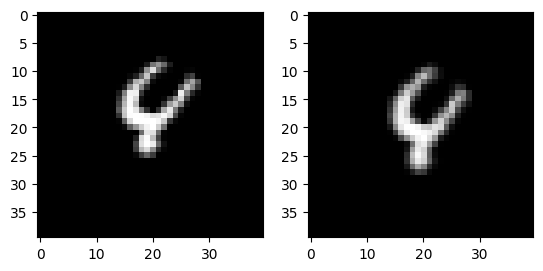

In [17]:
plt.subplot(1,2,1)
plt.imshow(X_test[12, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(prediction[12, :, :, 0], cmap='gray')